C:\Users\User\Anaconda3\envs\py39torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model name: Liu2023Comprehensive_Swin-L


Downloading...
From (original): https://drive.google.com/uc?id=1-57sQfcrsDsslfDR18nRD7FnpQmsSBk7
From (redirected): https://drive.google.com/uc?id=1-57sQfcrsDsslfDR18nRD7FnpQmsSBk7&confirm=t&uuid=47d541b0-30e4-4554-9c27-8a24ef1d4f09
To: C:\Users\User\AA -jupyter notebook\github\ATOS\models\imagenet\Linf\Liu2023Comprehensive_Swin-L.pt
100%|███████████████████████████████████████████████████████████████████████████████| 788M/788M [06:09<00:00, 2.13MB/s]


dataset_type: imagenet
Standard accuracy: 1.0
1 .   batch size : 4
CE loss,   c  : 0.5   c_l0  : 0.0   c_group  : 0.15   c_linf  : 0.2   number of attacked : 1
CE loss,   c  : 1.0   c_l0  : 0.0   c_group  : 0.15   c_linf  : 0.2   number of attacked : 2
CE loss,   c  : 2.0   c_l0  : 0.0   c_group  : 0.15   c_linf  : 0.2   number of attacked : 3
CE loss,   c  : 4.0   c_l0  : 0.0   c_group  : 0.15   c_linf  : 0.2   number of attacked : 3
CE loss,   c  : 8.0   c_l0  : 0.0   c_group  : 0.15   c_linf  : 0.2   number of attacked : 4
    num_blocks_mean: 1       num_blocks_std: 0       num_blocks_max: 1 
    norm1_mean: 671.505       norm1_std: 426.342       norm1_max: 1369.561 
    norm2_mean: 10.406       norm2_std: 4.437       norm2_max: 17.533 
    *linf_mean: 0.432       linf_std: 0.112       linf_max: 0.576 
    *norm0_mean: 9206.5       norm0_std: 4069.296       norm0_max: 14483.0 
    *number_pert_mean: 3385.0       number_pert_std: 1580.58       number_pert_max: 5602.0 
     ****accur

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

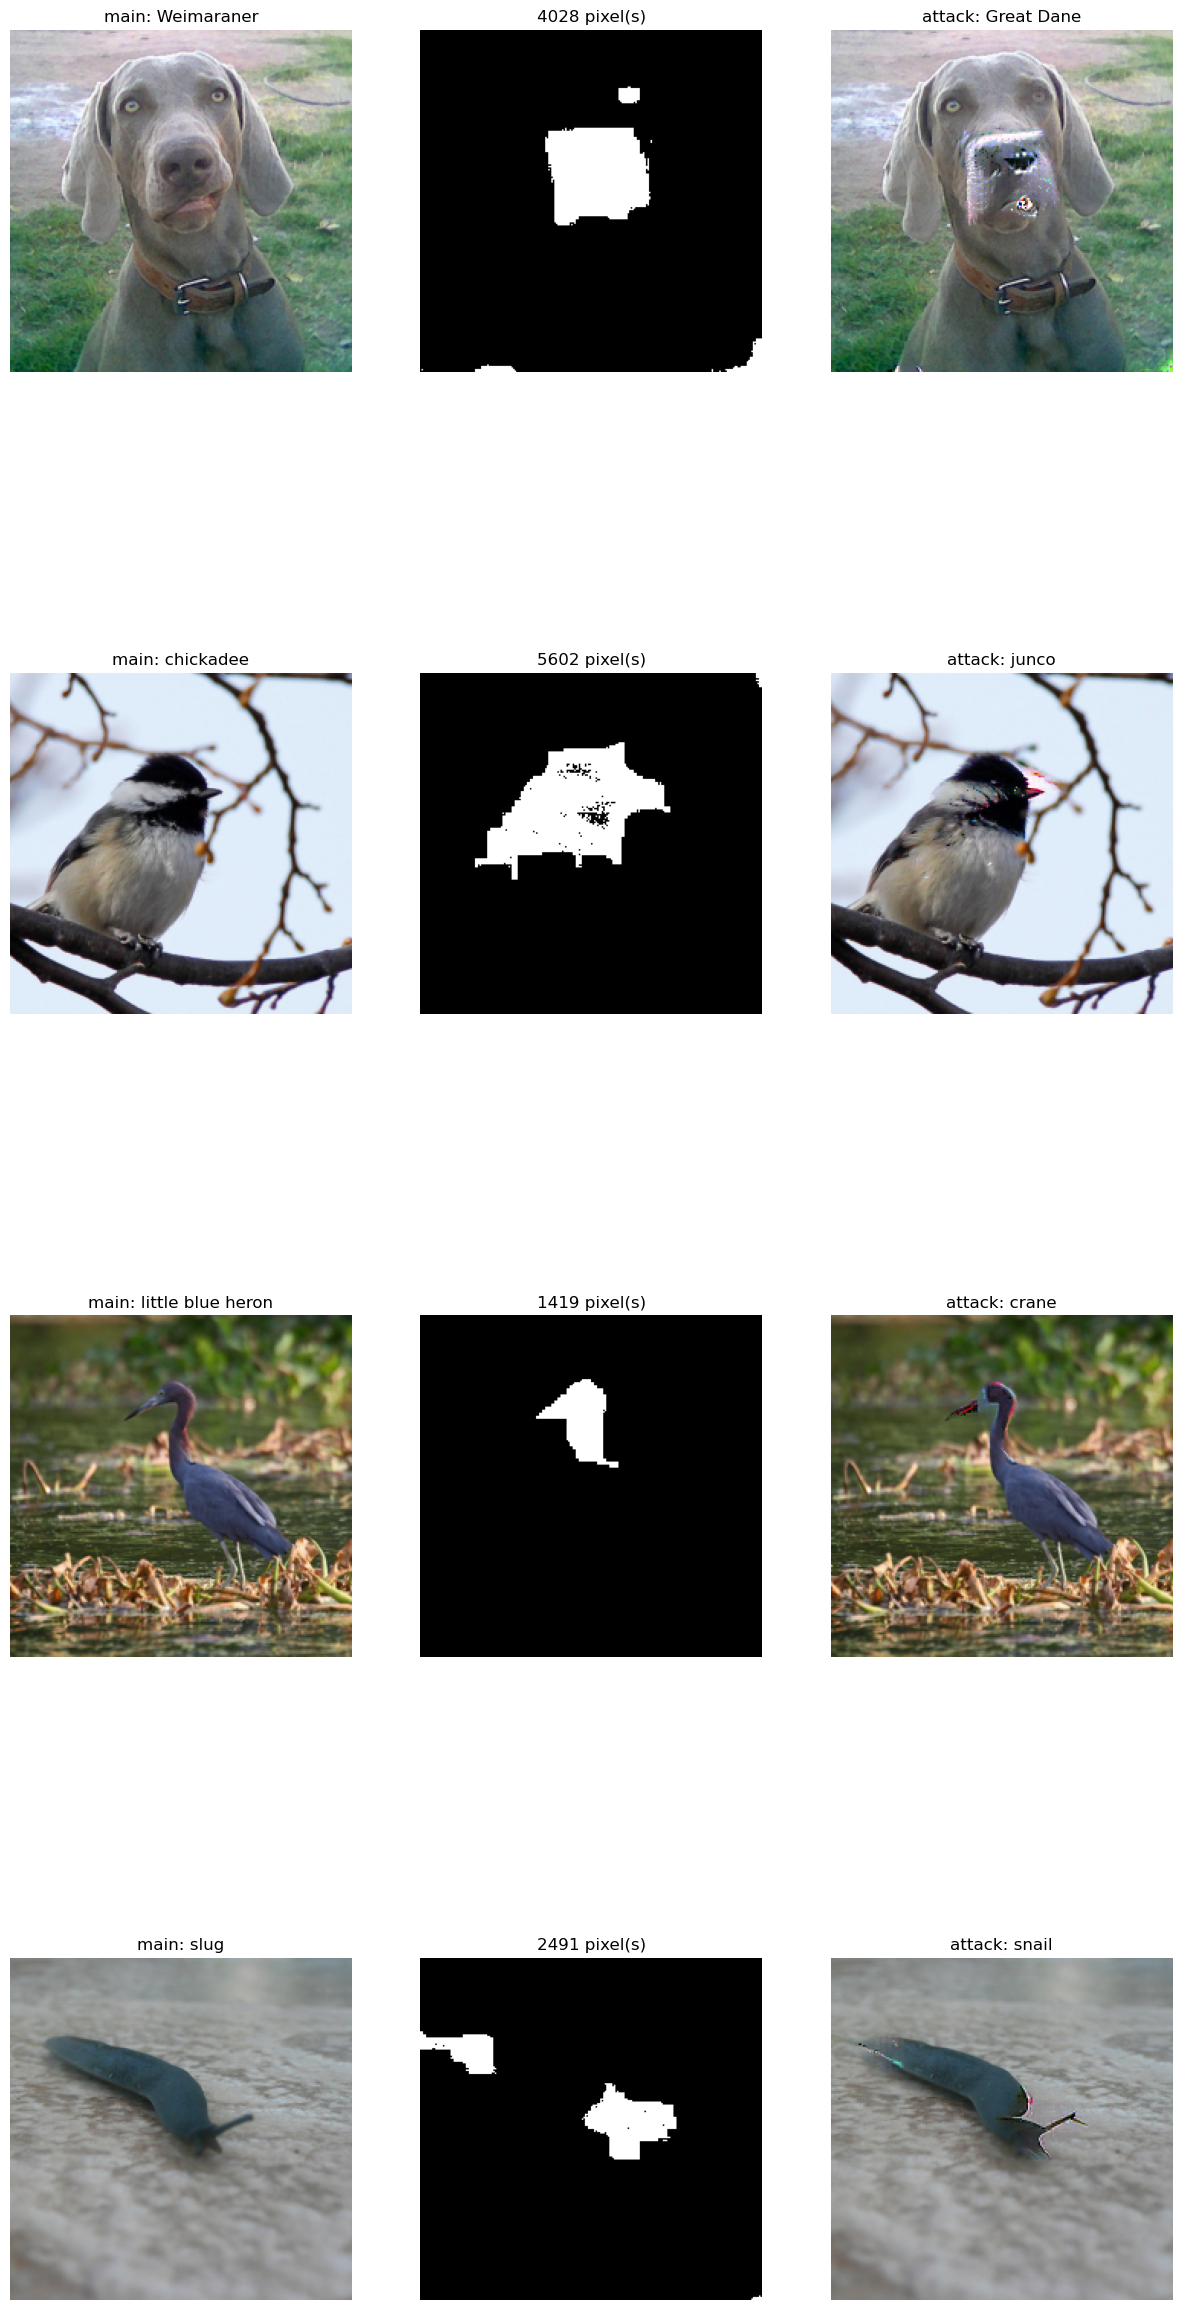

In [1]:

"""
@author: Alireza Heshmati
"""

import torch
import numpy as np
import random
import timeit
from os.path import exists
import pickle
import copy
from models import pretrained_model
from dataio import data_preparing
from execution import execute_attack
from utils import print_norm_and_accuracy, plot_results, calculate_result, create_blocks
from arguments import arg


torch.manual_seed(12)
torch.cuda.manual_seed_all(12)
torch.backends.cudnn.deterministic = True

np.random.seed(12)
random.seed(12)

if torch.cuda.device_count() != 0:
    device = torch.device('cuda:0')
else :
    device = torch.device('cpu')
    

# Robust Network over ImageNet Dataset
    
parser = arg()
args, unknown = parser.parse_known_args()
args.model_name = 'Liu2023Comprehensive_Swin-L'
print(f"model name: {args.model_name}")
# best batch 150
net = pretrained_model( args.model_name).to(device)


# load data
args.dataset_type = 'imagenet'
im_net_th= 4
print(f"dataset_type: {args.dataset_type}")
attack_data_test,attack_label_test = data_preparing(net, dataset_type= args.dataset_type,
                                                    device= device, im_net_th= im_net_th)
print(f"Standard accuracy: {len(attack_data_test)/im_net_th}" )

#Untargeted
args.dmax = 0.05

args.size_of_image = 224
args.grouped_stride = 2
args.grouped_len_window = 16

torch.cuda.empty_cache()
torch.manual_seed(12)
torch.cuda.manual_seed_all(12)
torch.backends.cudnn.deterministic = True
np.random.seed(12)
random.seed(12)

last = 4 #args.num_datas
args.attack_batch = 4
args.c = 0.5
args.s_c = 2
args.number_of_modifying = 10
args.learning_rate = 0.2
args.c_l0 = 0.0
args.s_sikma = 0.7
args.c_linf = 0.2

args.grouped_mode = True
args.c_group = 0.15

adv_deltas = torch.zeros_like(attack_data_test[:last])
adv_acc = torch.ones_like(attack_label_test[:last]).numpy()

blocks = create_blocks(stride = args.grouped_len_window ,len_window = args.grouped_len_window,
                          size_of_image = args.size_of_image,number_of_channel = args.number_of_channel)


start = timeit.default_timer()
k=0
for i in range(0, last, args.attack_batch):
    if 0 >= len(adv_acc[i:i+args.attack_batch]):
        break
    k=k+1
    print(k,'.','  batch size :', len(adv_acc[i:i+args.attack_batch]))
    adv_deltas[i:i+args.attack_batch],\
    adv_acc[i:i+args.attack_batch] =execute_attack(net, attack_data_test[:last][i:i+args.attack_batch], 
                                                   attack_label_test[:last][i:i+args.attack_batch] , blocks , args,device) 

stop = timeit.default_timer()
time =stop - start

torch.cuda.empty_cache()



    
if all(adv_acc==0) :
    print('****** No Atack ******')
    result = calculate_result(adv_deltas[:1], adv_acc, time,blocks)
else :
    result = calculate_result(adv_deltas[adv_acc == 1], adv_acc, time,blocks)

if args.group_mode:
    group_mode = 'Grouped'
else: 
    group_mode = 'Simple'

print_norm_and_accuracy(result)

print('   total Time (min) : ', round((time)/60, 3) ,"   time per image (sec) :", round((time) /last, 3)) 

if args.plot :
    np = args.number_of_plots
    outputs = net((attack_data_test[:np]+adv_deltas[:np]).to(device))
    fool_labels = torch.argmax(outputs, 1)
    plot_results(attack_data_test[:np], attack_data_test[:np]+adv_deltas[:np],attack_label_test[:np], fool_labels[:np] ,
                 imagenet_or_cifar10 = args.dataset_type)